In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

reference：https://www.kaggle.com/code/maquej/bike-sharing-demand0714

### 读入数据并预处理
对因变量取对数，检查缺失值

In [2]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
#取对数：+1防止出现log0的情况
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.000000,0.693147,0.693147


In [5]:
train.isna().sum()#没有缺失值，不需要填补

datetime          0
season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
casual            0
registered        0
count             0
casual_log        0
registered_log    0
count_log         0
dtype: int64

### 处理日期
从日期中提取月份、日期等信息，并将休假和工作日分开

In [6]:
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# 纳税日需要工作
train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# 感恩节不需要工作
test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# 圣诞节不需要工作
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0

#暴雨
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#海啸
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [7]:
#提取年份、月份、日期等信息
from datetime import datetime

def time_process(df):
    df['year'] = pd.DatetimeIndex(df.index).year
    df['month'] = pd.DatetimeIndex(df.index).month
    df['day'] = pd.DatetimeIndex(df.index).day
    df['hour'] = pd.DatetimeIndex(df.index).hour
    df['week'] = pd.DatetimeIndex(df.index).weekofyear
    df['weekday'] = pd.DatetimeIndex(df.index).dayofweek
    return df

train = time_process(train)
test = time_process(test)

In [8]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,casual_log,registered_log,count_log,year,month,day,hour,week,weekday
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,1.386294,2.639057,2.833213,2011,1,1,0,52,5
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,2.197225,3.496508,3.713572,2011,1,1,1,52,5


## 可视化分析
### 1.一天中不同时间段的影响

<AxesSubplot:xlabel='hour', ylabel='count'>

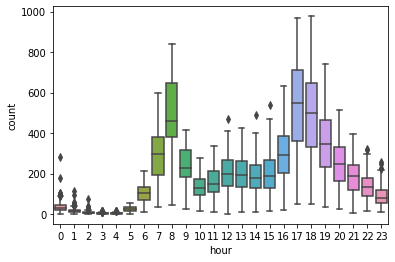

In [9]:
#工作日
sns.boxplot(x='hour',y='count',data=train[train['workingday'] == 1])

<AxesSubplot:xlabel='hour', ylabel='count'>

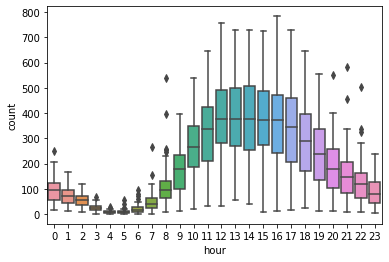

In [10]:
#非工作日
sns.boxplot(x='hour',y='count',data=train[train['workingday'] == 0])

可以发现，在工作日中的高峰期是早上8点和下午17点、18点；在非工作日中的高峰期是10点到19点。将这些时间段标记为高峰期。

<AxesSubplot:xlabel='hour', ylabel='count'>

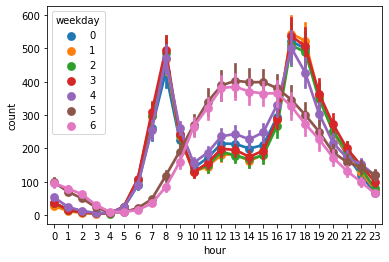

In [11]:
#星期几对应的使用量。可以明显发现非工作日和工作日的使用曲线分别高度重合，具有普遍规律
sns.pointplot(x='hour',y='count',hue='weekday',join=True,data=train)

In [12]:
train['peak'] = train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
test['peak'] = test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

### 2. 不同月份对使用量的影响
可以发现集中在夏季

<AxesSubplot:xlabel='month', ylabel='count'>

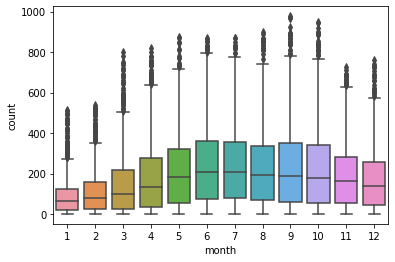

In [13]:
sns.boxplot(x='month',y='count',data=train)

### 3.不同天气
可见天气情况对使用量有明显影响

<AxesSubplot:xlabel='weather', ylabel='count'>

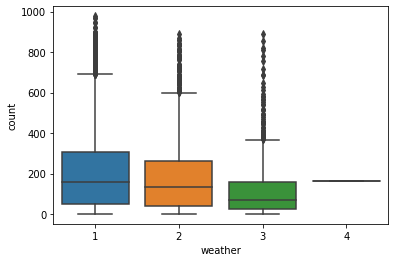

In [14]:
sns.boxplot(x='weather',y='count',data=train)

### 4.星期几对使用量的影响
可见工作日和非工作日有明显的差距；工作日之间没有显著的差距

<AxesSubplot:xlabel='weekday', ylabel='count'>

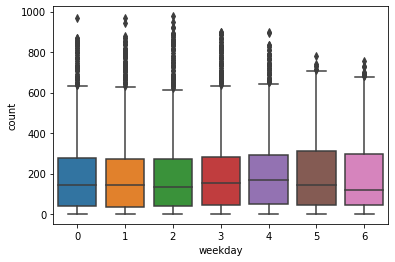

In [15]:
sns.boxplot(x='weekday',y='count',data=train)

是否是工作日：可见工作日使用量明显高于非工作日

<AxesSubplot:xlabel='workingday', ylabel='count'>

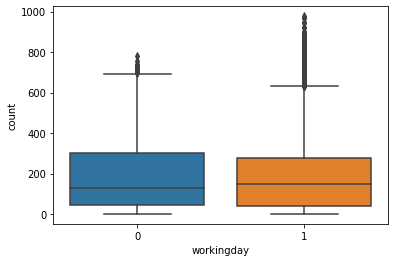

In [16]:
sns.boxplot(x='workingday',y='count',data=train)

### 5.是否注册用户
可见注册用户具有和【工作日中的时间-使用量】相似的使用曲线；而非注册用户则具有和【非工作日中的时间-使用量】相似的使用曲线

<AxesSubplot:xlabel='hour', ylabel='casual'>

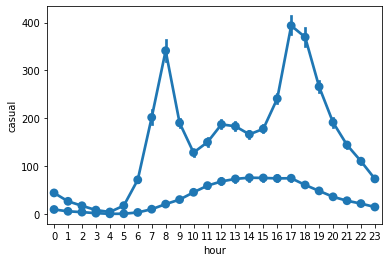

In [17]:
sns.pointplot(x='hour',y='registered',hue=None,join=True,data=train)
sns.pointplot(x='hour',y='casual',hue=None,join=True,data=train)

进一步分析可以发现，和注册用户相比，非注册用户更倾向于在非工作日中使用自行车

<AxesSubplot:xlabel='hour', ylabel='registered'>

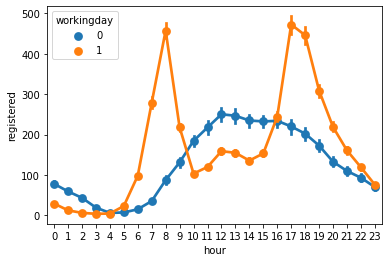

In [18]:
#注册用户
sns.pointplot(x='hour',y='registered',hue='workingday',join=True,data=train)

<AxesSubplot:xlabel='hour', ylabel='casual'>

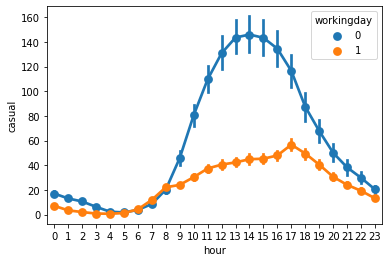

In [19]:
#非注册用户
sns.pointplot(x='hour',y='casual',hue='workingday',join=True,data=train)

### 6.环境对使用量的影响

([<matplotlib.axis.XTick at 0x7f8bdd8b8a10>,
 [Text(0, 0, '0.82'),
  Text(1, 0, '1.64'),
  Text(2, 0, '2.46'),
  Text(3, 0, '3.28'),
  Text(4, 0, '4.1')])

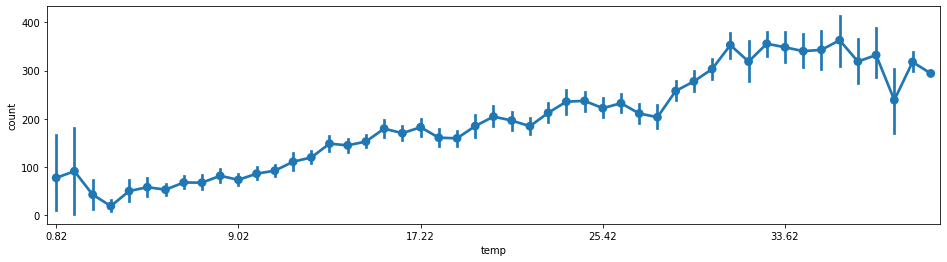

In [20]:
#温度--使用量
fig = plt.subplots(figsize=(16,4))
sns.pointplot(x='temp',y='count',join=True,data=train)
plt.xticks([0,10,20,30,40])

([<matplotlib.axis.XTick at 0x7f8bdda3ef50>,
 [Text(0, 0, '0.76'),
  Text(1, 0, '1.515'),
  Text(2, 0, '2.275'),
  Text(3, 0, '3.03'),
  Text(4, 0, '3.79')])

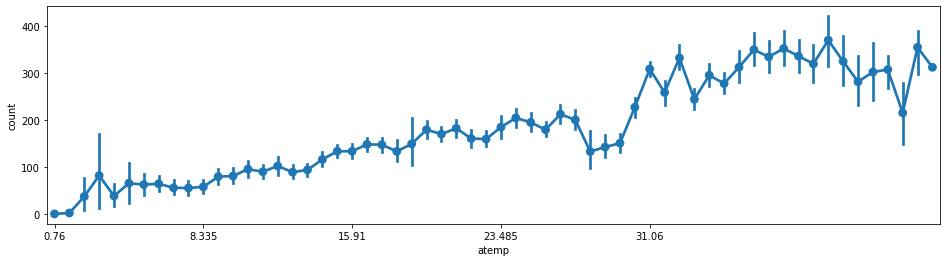

In [21]:
#体感温度--使用量
fig = plt.subplots(figsize=(16,4))
sns.pointplot(x='atemp',y='count',join=True,data=train)
plt.xticks([0,10,20,30,40])

([<matplotlib.axis.XTick at 0x7f8bdd7882d0>,
 [Text(0, 0, '0'),
  Text(1, 0, '8'),
  Text(2, 0, '10'),
  Text(3, 0, '12'),
  Text(4, 0, '13'),
  Text(5, 0, '14'),
  Text(6, 0, '15'),
  Text(7, 0, '16'),
  Text(8, 0, '17'),
  Text(9, 0, '18')])

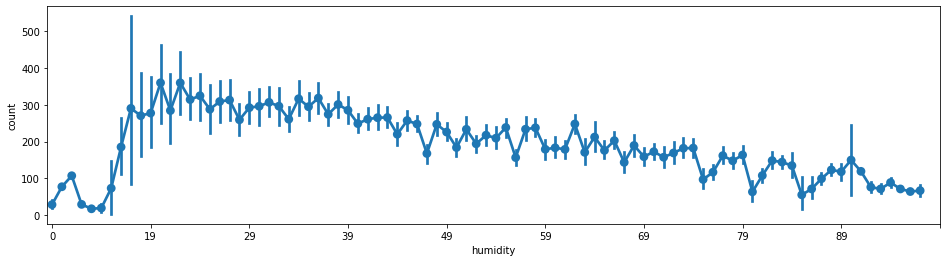

In [22]:
#湿度-使用量
fig = plt.subplots(figsize=(16,4))
sns.pointplot(x='humidity',y='count',join=True,data=train)
plt.xticks([0,10,20,30,40,50,60,70,80,90])

([<matplotlib.axis.XTick at 0x7f8bdd2bac50>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '6.0032'),
  Text(2, 0, '7.0015'),
  Text(3, 0, '8.9981'),
  Text(4, 0, '11.0014'),
  Text(5, 0, '12.998')])

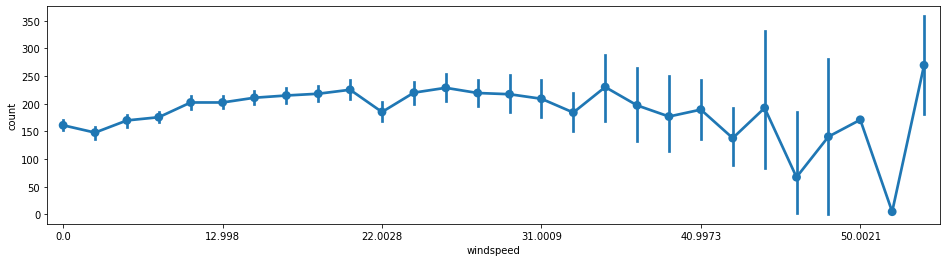

In [23]:
#风速-使用量
fig = plt.subplots(figsize=(16,4))
sns.pointplot(x='windspeed',y='count',join=True,data=train)
plt.xticks([0,5,10,15,20,25])

## 相关性分析
对连续型变量分析其相关性，可见体感温度和温度有极大的相关性。事实上，体感温度取决于温度和湿度，因而可以直接去除体感温度。

<AxesSubplot:>

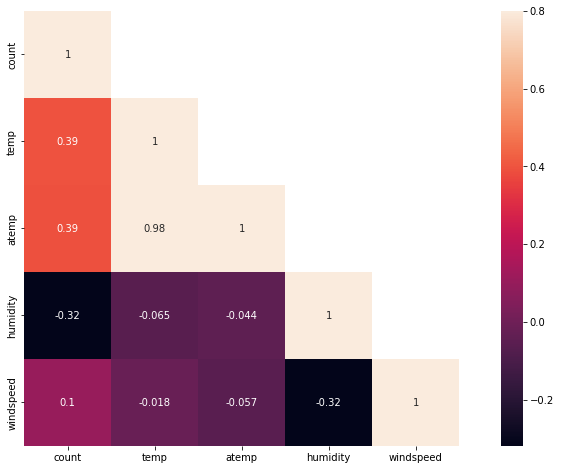

In [24]:
corr = train[['count','temp','atemp','humidity','windspeed']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(corr,mask=mask,vmax=.8,square=True,annot=True)

In [25]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'casual_log', 'registered_log', 'count_log', 'year', 'month', 'day',
       'hour', 'week', 'weekday', 'peak'],
      dtype='object')

## 训练
由于注册用户与未注册用户在特征上明显不同，所以分开预测casual和registered，结果再将两者合并即可。casual + registered = count。

采用xgboost+random forest，虽然包括random forest在内的模型在cross validation上表现很不错，但实际上还是存在过拟合，且使用随机交换特征等数据增强的效果也不怎么好。由于这两种模型都是tree-based的方法，它们**不适合使用包括one-hot以及异常值去除等**数据处理方式，甚至也不需要归一化，只需要将数据处理得尽可能接近正态分布即可（取log）

In [26]:
rf_columns = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'week', 'peak',
]
gb_columns =[
    'weather', 'temp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'weekday', 'year', 
]

In [27]:
#训练数据
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

y_casual=train['casual_log'].values
y_registered=train['registered_log'].values
y=train['count_log'].values

x_date=test['datetime'].values

In [28]:
#random forest
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 1000, 
          'max_depth': 15, 
          'random_state': 0, 
          'min_samples_split' : 2, #为什么设为2：（1）因为存在0-1变量（2）存在过拟合
          'n_jobs': -1}

rf_c = RandomForestRegressor(**params)
rf_c.fit(rf_x_train,y_casual)
print('casual:',rf_c.score(rf_x_train,y_casual))

rf_r = RandomForestRegressor(**params)
rf_r.fit(rf_x_train,y_registered)
print('registered:',rf_r.score(rf_x_train,y_registered))

casual: 0.9726067525351507
registered: 0.9808557797583348


In [29]:
#xgb
import xgboost as xgb
xgb_c = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, random_state = 0,n_estimators=200)
xgb_c.fit(gb_x_train, y_casual)
print('casual:',xgb_c.score(gb_x_train,y_casual))

xgb_r = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, random_state = 0,n_estimators=200)
xgb_r.fit(gb_x_train, y_registered)
print('registered:',xgb_r.score(gb_x_train,y_registered))

casual: 0.9235170841306428
registered: 0.9712917213282761


In [30]:
#GB（没有xgb的效果好，弃之）
from sklearn.ensemble import GradientBoostingRegressor

params2 = {'n_estimators': 150, 
           'max_depth': 5, 
           'random_state': 0, 
           'min_samples_leaf' : 10, 
           'learning_rate': 0.1, 
           'subsample': 0.7, 
           'loss': 'ls'}

gb_c = GradientBoostingRegressor(**params2)
gb_c.fit(gb_x_train,y_casual)
print('casual:',gb_c.score(gb_x_train,y_casual))

gb_r = GradientBoostingRegressor(**params2)
gb_r.fit(gb_x_train,y_registered)
print('registered:',gb_r.score(gb_x_train,y_registered))

casual: 0.9195514835772132
registered: 0.968499680058303


In [31]:
rf_pre_count = np.exp(xgb_c.predict(gb_x_test))+np.exp(rf_r.predict(rf_x_test))-2
xgb_pre_count = np.exp(xgb_c.predict(gb_x_test))+np.exp(xgb_r.predict(gb_x_test))-2

pre_count=np.round(0.2*rf_pre_count+0.8*xgb_pre_count,0)#最后记得round一下
submit = pd.DataFrame({'datetime':x_date,'count':pre_count})
submit.to_csv('/kaggle/working/submisssion.csv',index=False)